# Exercise 3 (Training with Bayes Optimization)

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import pandas as pd
import pickle

path_train = '../pickle/fraud/data/preprocessed_train.pkl'
path_test = '../pickle/fraud/data/preprocessed_test.pkl'
data_train:pd.DataFrame = pickle.load(open(path_train, 'rb'))
data_test = pickle.load(open(path_test, 'rb'))

print(data_train.shape)
print(data_test.shape)

(472432, 53)
(118108, 53)


## Undersampling

In [3]:
data_train = data_train.drop(data_train[data_train['isFraud'] == 0].sample(n=data_train[data_train['isFraud'] == 0].shape[0]-16421).index)
print(data_train.shape)

(32842, 53)


## Oversampling

In [4]:
from collections import Counter
from imblearn.over_sampling import ADASYN

X_train, y_train = data_train.drop('isFraud', axis=1), data_train['isFraud']
X_test, y_test = data_test.drop('isFraud', axis=1), data_test['isFraud']

ada = ADASYN(random_state=42)
X_train_res, y_train_res = ada.fit_resample(X_train, y_train)

In [5]:
print("Original train")
print(f"0: {Counter(y_train)[0]} ({round(Counter(y_train)[0]/len(y_train)*100, 1)}%)")
print(f"1: {Counter(y_train)[1]} ({round(Counter(y_train)[1]/len(y_train)*100, 1)}%)")
print()
print("Resampled train")
print(f"0: {Counter(y_train_res)[0]} ({round(Counter(y_train_res)[0]/len(y_train_res)*100, 1)}%)")
print(f"1: {Counter(y_train_res)[1]} ({round(Counter(y_train_res)[1]/len(y_train_res)*100, 1)}%)")
print()
print("Test")
print(f"0: {Counter(y_test)[0]} ({round(Counter(y_test)[0]/len(y_test)*100, 1)}%)")
print(f"1: {Counter(y_test)[1]} ({round(Counter(y_test)[1]/len(y_test)*100, 1)}%)")

Original train
0: 16421 (50.0%)
1: 16421 (50.0%)

Resampled train
0: 16421 (50.0%)
1: 16421 (50.0%)

Test
0: 113866 (96.4%)
1: 4242 (3.6%)


## Training

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from skopt.space import Real, Categorical, Integer

nb_col = X_train.shape[1]

dict_models = [
    {
        'name_clf' : 'Random Forest',
        'model': RandomForestClassifier(random_state=42),
        'scalers' : {
            'scaler': Categorical([None]),
        },  
        'grid' : {
            'model__max_depth': Integer(1, nb_col),
            'model__n_estimators': Integer(10, 200),
            
        },
    },

    {
        'name_clf' : 'SVC (poly)',
        'model': SVC(random_state=42, kernel='poly'),
        'scalers' : {
            'scaler': Categorical([None, MinMaxScaler(), StandardScaler()]),
        },
        'grid' : {
            'model__C': Real(0.001, 1000),
        },
    },

    # {
    #     'name_clf' : 'SVC (linear)',
    #     'model': SVC(random_state=42, kernel='linear'),
    #     'scalers' : {
    #         'scaler': Categorical([MinMaxScaler(), StandardScaler()]),
    #     },
    #     'grid' : {
    #         'model__C': Real(0.001, 1000),
    #     },
    # },

    {
        'name_clf' : 'SVC (rbf)',
        'model': SVC(random_state=42, kernel='rbf'),
        'scalers' : {
            'scaler': Categorical([None, MinMaxScaler(), StandardScaler()]),
        },
        'grid' : {
            'model__C': Real(0.001, 1000),
        },
    },

    {
        'name_clf' : 'SVC (sigmoid)',
        'model': SVC(random_state=42, kernel='sigmoid'),
        'scalers' : {
            'scaler': Categorical([None, MinMaxScaler(), StandardScaler()]),
        },
        'grid' : {
            'model__C': Real(0.001, 1000),
        },
    },    
]

In [7]:
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from time import time
from utils import model_evaluation_clf
import os

import warnings
warnings.filterwarnings("ignore")

results = pd.DataFrame(columns=["Model", "CPU time", "Accuracy", "Precision", "Recall", "f1-score", "AUC"])
models = {}
nb_res = 0

for i, dict_clf in enumerate(dict_models):
    model_name = dict_clf['name_clf']
    model_path = f"../pickle/fraud/models/BayesSearchCV/{model_name}.pkl"
    model_time = f"../pickle/fraud/CPU_time/BayesSearchCV/{model_name}_time.pkl"
    if not os.path.exists(model_path) or not os.path.exists(model_time):
        print(f'Training {model_name}...')

        model = dict_clf['model']

        steps = [
            ('scaler', None),
            ('model', model),
        ]

        pipeline = Pipeline(steps)

        param_grid = {
            **dict_clf['scalers'],
            **dict_clf['grid']
        }

        clf = BayesSearchCV(pipeline, search_spaces=param_grid, cv=5, n_iter=10, n_jobs=-1, verbose=1, scoring='roc_auc', random_state=42)

        warnings.filterwarnings("ignore")
        start_time = time()
        clf.fit(X_train_res, y_train_res)
        end_time = time()
        duration = round(end_time - start_time, 1)
        print(f"CPU Time: {duration}s")

        pickle.dump(clf, open(model_path, 'wb'))
        pickle.dump(duration, open(model_time, 'wb'))
    else:
        clf = pickle.load(open(model_path, 'rb'))
        duration = pickle.load(open(model_time, 'rb'))

    
    print(f"Best params {model_name}: \n{clf.best_params_}")

    eval = model_evaluation_clf(clf, X_test, y_test)
    
    models[model_name] = clf

    results.loc[nb_res] = [model_name, duration, eval['accuracy'], eval['precision'], eval['recall'], eval['f1'], eval['roc_auc']]
    nb_res += 1

    print()

Best params Random Forest: 
OrderedDict([('model__max_depth', 24), ('model__n_estimators', 185), ('scaler', None)])

Best params SVC (poly): 
OrderedDict([('model__C', 799.5536420537316), ('scaler', MinMaxScaler())])

Best params SVC (rbf): 
OrderedDict([('model__C', 3.6313036244359718), ('scaler', StandardScaler())])

Best params SVC (sigmoid): 
OrderedDict([('model__C', 3.6313036244359718), ('scaler', StandardScaler())])



In [8]:
results = results.sort_values(by='AUC', ascending=False)
print(results.to_string(index=False))

        Model  CPU time  Accuracy  Precision  Recall  f1-score   AUC
Random Forest      61.5     0.963      0.490   0.991     0.656 0.976
   SVC (poly)    7241.5     0.961      0.480   0.955     0.638 0.958
    SVC (rbf)     492.4     0.963      0.492   0.950     0.649 0.957
SVC (sigmoid)     310.0     0.735      0.093   0.725     0.164 0.730


With 10 iterations, we have almost the same results as the GridSearchCV. However, the training with Bayes optmization is different than the GridSearchCV. For exemple, it's almost 20 times faster for Radom Forest and twice faster for SVC. We can notice a small difference in the results, but it's not significant.

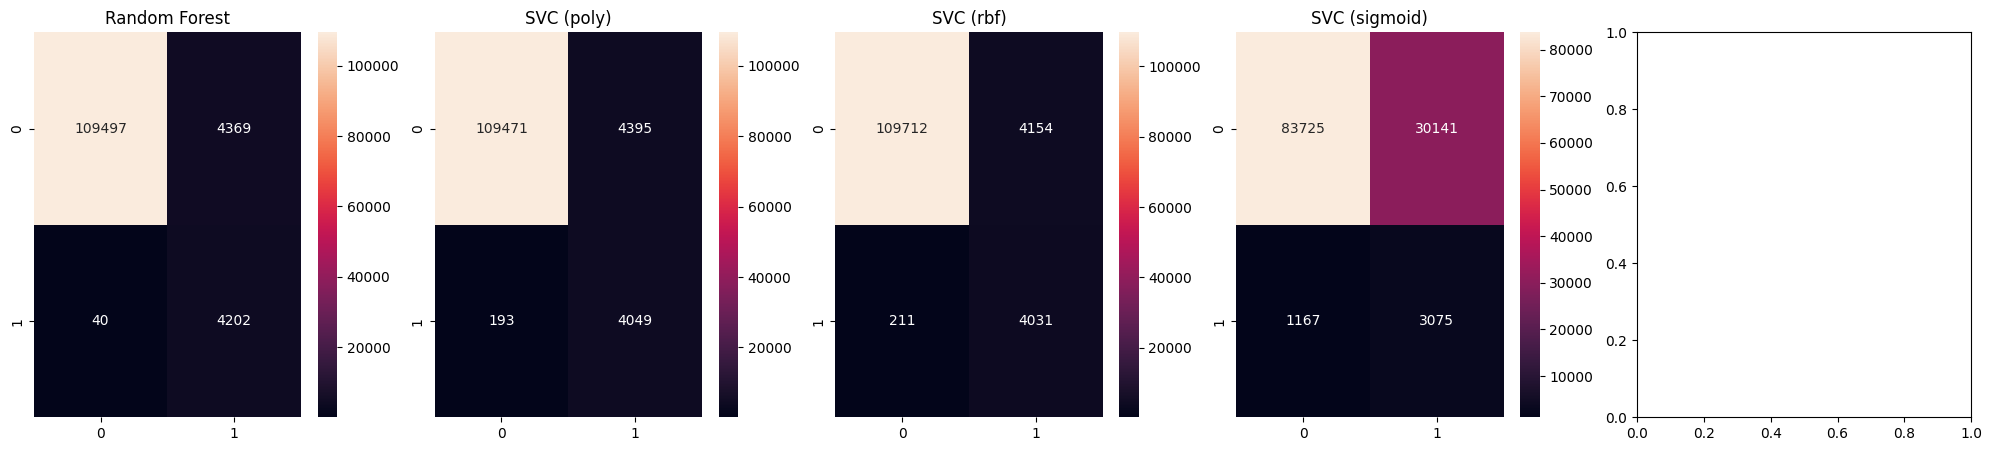

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for i, model_name in enumerate(models.keys()):
    model = models[model_name]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axs[i])
    axs[i].set_title(model_name)

plt.show()

Even though we have a good AUC score, the confusion matrix shows that we don't avoid false positives (non-fraudulent transactions classified as fraudulent). This is a problem because it can lead to the blocking of legitimate transactions. However we can see that the number of false negatives (fraudulent transactions classified as non-fraudulent) is very low. This is a good point because it means that we don't miss many fraudulent transactions.

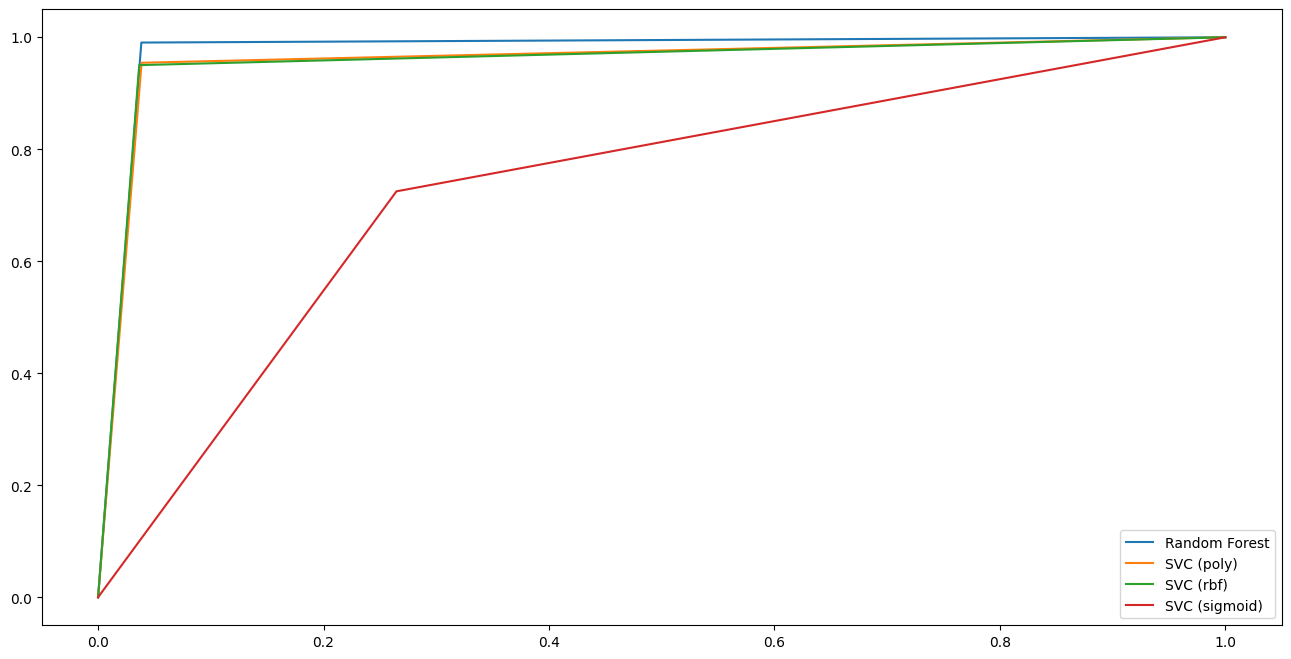

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fig, ax = plt.subplots(figsize=(16, 8))

for model_name in models.keys():
    model = models[model_name]
    y_pred = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    ax.plot(fpr, tpr, label=model_name)

plt.legend()
plt.show()

This figure shows the ROC curve of the different models. The closer the curve is to the top left corner, the better the model is. The Random Forest model is the best model in this case.

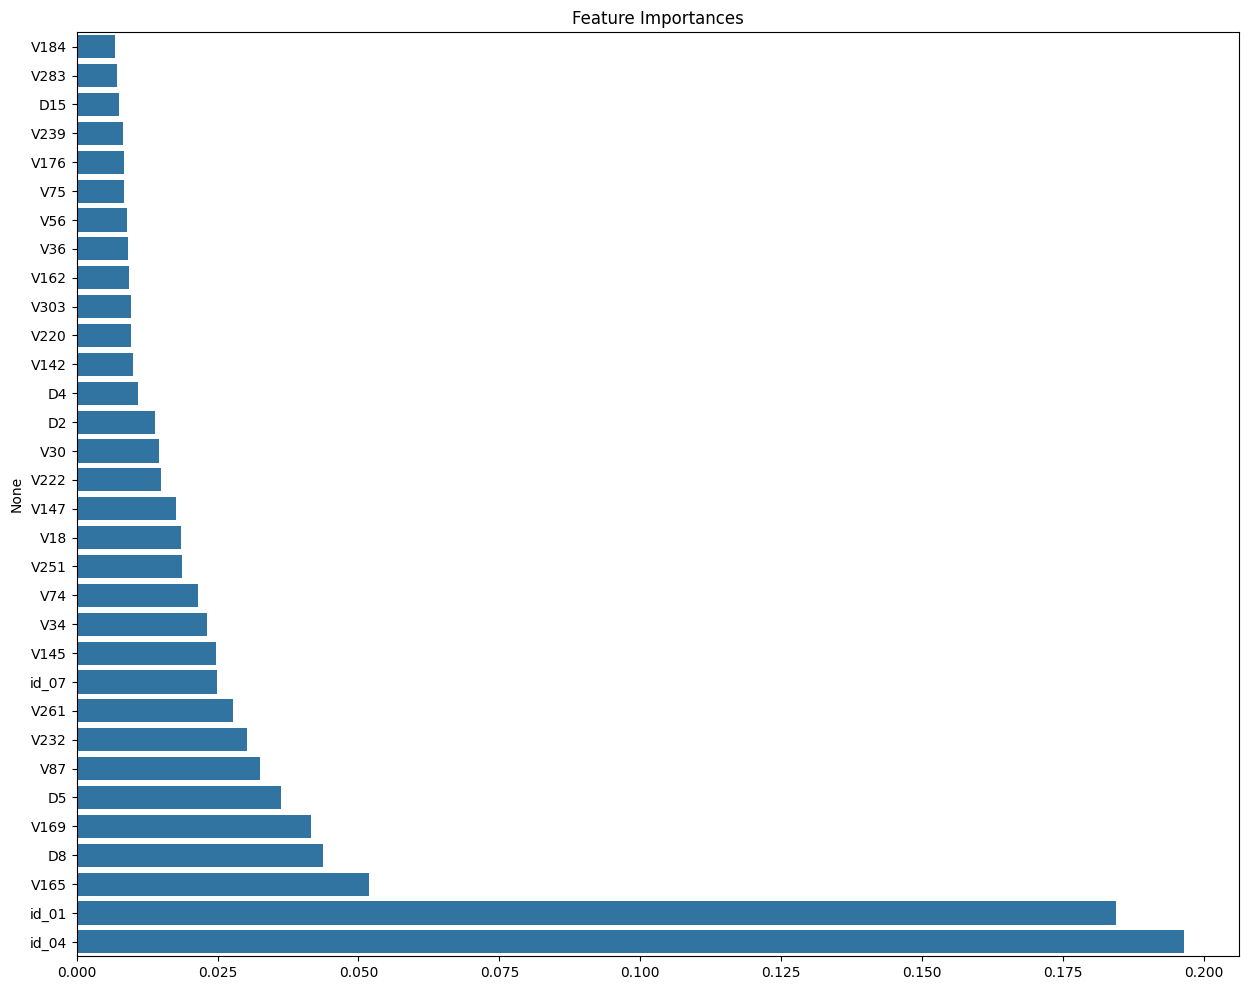

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

model = models['Random Forest']

importances = model.best_estimator_.named_steps['model'].feature_importances_
indices = importances.argsort()[20:]

plt.figure(figsize=(15, 12))
sns.barplot(x=importances[indices], y=X_train.columns[indices])
plt.title('Feature Importances')
plt.show()

As we can see with the feature importances, the most important feature is 'id_04' and 'id_01' by far which is the same as the previous notebook. The other features can be a bit different but the most important ones are still the same.

## Model selection

After these analysis, we can be sure that the Random Forest model is the best model for this dataset. It has the best AUC and it is also the fastest model to train. Moreover which have significant speed up compared to GridSearch so to find the best hyperparameters, we prefere to use BayesSearchCV.